In [1]:
import utils

f0_predictor = utils.get_f0_predictor('rmvpe',
                                        sampling_rate=44100,
                                        hop_length=512,
                                        device='cuda',
                                        threshold=0.05)

In [2]:
import librosa
wav, sr = librosa.load("notebook/test_audios/ref_audio/24k_xigua.wav", sr=44100)

In [3]:
import time


f0, uv = f0_predictor.compute_f0_uv(wav)


In [8]:
import yaml
config = yaml.safe_load(open('configs/pretrained/config.yaml'))

In [11]:
config.update()

In [2]:
all_data = []
with open("Data/backup/raw_text_en.list", 'r') as f:
    for line in f:
        all_data.append(line.strip())
with open("Data/raw_text.list", 'r') as f:
    for line in f:
        all_data.append(line.strip())

In [4]:
import random

random.shuffle(all_data)

valid = all_data[:10]
train = all_data[10:]

In [6]:
with open("Data/sovits_svc/train.list",'w') as f:
    for line in train:
        line = line.strip()
        f.write(line + '\n')

with open("Data/sovits_svc/dev.list",'w') as f:
    for line in valid:
        line = line.strip()
        f.write(line + '\n')

In [3]:
with open("Data/raw_text.list",'w') as f:
    for line in all_data:
        line = line.strip()
        f.write(line + '\n')

In [13]:
import os
from pathlib import Path


dir = "ckpts/sunyanzi/audio_slice/sunyanzi"
p = Path(dir)

In [9]:
def move_files_simple(source_dir, target_dir):
    source_path = Path(source_dir)
    target_path = Path(target_dir)
    
    # 确保目标目录存在
    target_path.mkdir(parents=True, exist_ok=True)
    
    # 移动所有文件
    for file_path in source_path.glob("*.wav"):
        if file_path.is_file():
            file_path.rename(target_path / file_path.name)
            print(f"Moved: {file_path.name}")

In [ ]:
move_files_simple(p, p.parent.parent/'sunyanzi')

In [5]:
from pathlib import Path

t = Path("ckpts/sunyanzi/audio_slice/sunyanzi/sunyanzi_000000.wav")

In [6]:
"_".join(t.stem.split('_')[:2]) + '_f0.npy'

'sunyanzi_000000_f0.npy'

In [9]:
any(t.glob("g_*.pth"))

False

In [8]:
 list(t.glob("g_*.pth"))

[]

In [ ]:
import sys
import os
import torch
import torch.backends.cudnn as cudnn

def check_environment():
    print("=== Python Environment ===")
    print(f"Python executable: {sys.executable}")
    print(f"Python version: {sys.version}")
    
    print("\n=== PyTorch Information ===")
    print(f"PyTorch location: {torch.__file__}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDNN version: {cudnn.version()}")
    
    print("\n=== Environment Variables ===")
    print(f"CONDA_PREFIX: {os.environ.get('CONDA_PREFIX', 'Not set')}")
    print(f"LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH', 'Not set')}")
    
    if torch.cuda.is_available():
        print("\n=== CUDA Device Information ===")
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        try:
            print(f"Device capability: {torch.cuda.get_device_capability()}")
        except AttributeError:
            pass
    
    print("\n=== Python Path ===")
    for path in sys.path:
        print(path)
    
    # 尝试定位 CUDA 相关库
    print("\n=== CUDA Library Check ===")
    torch_path = os.path.dirname(torch.__file__)
    print(f"Looking for CUDA libraries in: {torch_path}")
    
    # 检查常见的库文件位置
    cuda_paths = [
        os.path.join(torch_path, 'lib'),
        os.environ.get('CONDA_PREFIX', ''),
        '/usr/local/cuda/lib64',
        '/usr/lib/x86_64-linux-gnu'
    ]
    
    for path in cuda_paths:
        if os.path.exists(path):
            print(f"\nChecking {path}:")
            cuda_libs = [f for f in os.listdir(path) if 'cuda' in f.lower() or 'cudnn' in f.lower()]
            for lib in cuda_libs:
                print(f"Found: {lib}")

if __name__ == "__main__":
    check_environment()

In [1]:
import torch

In [2]:
# sovits底膜专用
def remove_optimizer(path):
    ckpt = torch.load(path, map_location='cpu')
    ckpt['optimizer'] = None
    torch.save(ckpt, path)
    

In [4]:
remove_optimizer("ckpts/test/sovits/backup/D_960000.pth")

In [1]:
from pathlib import Path

model_dir = Path("ckpts/sunyanzi/diffusion")

In [5]:
f_list = list(model_dir.glob("*.pt"))

f_list.sort(
    key=lambda f: int("".join(filter(str.isdigit, f))))

In [1]:
import os

len(os.listdir("/datadisk/liujunjie/so-vits-svc/raw_audios/preprocess/sing_10s/timbre_feature"))

69729

In [ ]:
from multiprocessing.managers import BaseManager
import time

def connect_to_server():
    # 定义QueueManager
    class QueueManager(BaseManager):
        pass

    # 注册队列
    QueueManager.register('get_train_queue')
    QueueManager.register('get_dev_queue')

    # 创建管理器实例
    manager = QueueManager(
        address=('127.0.0.1', 12345),
        authkey=b'liujunjieabracadabra'
    )

    # 尝试连接
    try:
        manager.connect()
        print("成功连接到服务器")
        return manager
    except Exception as e:
        print(f"连接失败: {e}")
        return None

def main():
    # 连接服务器
    manager = connect_to_server()
    if not manager:
        return

    # 获取队列
    train_queue = manager.get_train_queue()
    # dev_queue = manager.get_dev_queue()

    # 持续从队列获取数据
    try:
        while True:
            # 尝试从训练队列获取数据
            try:
                train_data = train_queue.get(timeout=5)  # 5秒超时
                print("收到训练数据:", train_data)
                # 这里处理train_data...
            except:
                print("训练队列暂无数据")

            # # 尝试从开发队列获取数据
            # try:
            #     dev_data = dev_queue.get(timeout=5)  # 5秒超时
            #     print("收到开发数据:", dev_data)
            #     # 这里处理dev_data...
            # except:
            #     print("开发队列暂无数据")

            time.sleep(1)  # 避免过于频繁的请求

    except KeyboardInterrupt:
        print("程序终止")
    except Exception as e:
        print(f"运行出错: {e}")

if __name__ == '__main__':
    main()

In [4]:
import os

len(os.listdir("/datadisk/liujunjie/so-vits-svc/Data/sovits_svc/f0s"))

1026100

In [1]:
data = []
with open("Data/raw_text.list",'r') as f:
    for line in f:
        data.append(line.strip())
len(data)

1024580

In [8]:
import random
random.shuffle(data)

data = data[:60000]

new_data = []

for line in data:
    line = line.strip().split("|")
    if len(line[2]) < 30:
        new_data.append(line)
    if len(new_data) > 60000:
        break



In [24]:
import json

sing_spk_info = json.load(open("Data/backup/sing_spk_info.json",'r'))
print(len(sing_spk_info))



952


In [25]:
sing_data = []
with open("/datadisk/liujunjie/so-vits-svc/Data/sing_raw_text.list",'r') as f:
    for line in f:
        line = line.strip()
        sing_data.append(line)
        

In [26]:
for line in new_data:
    # line = line.strip().split("|")
    if line[2] not in sing_spk_info:
        sing_spk_info[line[2]] = len(sing_spk_info)
    sing_data.append("|".join(line))

json.dump(sing_spk_info,open("Data/sovits_svc/sing_spk_info.json",'w'),indent=4,ensure_ascii=False)


In [27]:
random.shuffle(sing_data)

with open("Data/sing_raw_text.list",'w') as f:
    for line in sing_data:
        f.write(line + '\n')

In [25]:
import os

len(os.listdir("Data/sovits_svc/ssls"))

1144036

In [3]:
import os
import shutil

data = []
with open("Data/sovits_svc/train.list",'r') as f:
    for line in f:
        line = line.strip().split("|")
        if line[2] == "Tenor":
            data.append(line[0])
        if len(data) > 1000:
            break

# Create target directory if it doesn't exist
os.makedirs("notebook/sovits_svc/data", exist_ok=True)

# Copy and rename files
for i, filename in enumerate(data):
    src = os.path.join("Data/sing_raw", filename + ".wav")
    dst = os.path.join("notebook/sovits_svc/data/Tenor", f"Tenor_{i+1:03d}.wav")
    shutil.copy2(src, dst)


In [ ]:
def copy_directory_contents(source_dir, target_dir):
    """
    将源目录下的所有内容（包括文件和子目录）复制到目标目录
    
    Args:
        source_dir (str): 源目录路径
        target_dir (str): 目标目录路径
    """
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 遍历源目录下的所有项目
    for item in os.listdir(source_dir):
        source_path = os.path.join(source_dir, item)
        target_path = os.path.join(target_dir, item)
        
        try:
            if os.path.isdir(source_path):
                # 如果是目录，递归复制
                shutil.copytree(source_path, target_path)
                print(f"成功复制目录: {item}")
            else:
                # 如果是文件，直接复制
                shutil.copy2(source_path, target_path)
                print(f"成功复制文件: {item}")
        except Exception as e:
            print(f"复制 {item} 时出错: {str(e)}")
                
name = '芙宁娜'

copy_directory_contents(f'raw_audios/Genshin_zh/{name}', f'ckpts/{name}/raw_audio')

In [10]:
import os
import shutil

def move_and_clean_files(base_dir):
    # 遍历指定目录的所有子目录
    for root, dirs, files in os.walk(base_dir, topdown=False):  # topdown=False 确保从底层目录开始
        if root == base_dir:  # 跳过基础目录
            continue
            
        for file in files:
            source_path = os.path.join(root, file)
            target_path = os.path.join(base_dir, file)
            
            # 检查目标位置是否已存在文件
            if os.path.exists(target_path):
                print(f"跳过已存在文件: {file}")
                continue
                
            try:
                # 移动文件到指定目录
                shutil.move(source_path, base_dir)
                print(f"移动文件: {file}")
            except Exception as e:
                print(f"移动文件 {file} 时出错: {str(e)}")
    
    # 删除空文件夹
    for root, dirs, files in os.walk(base_dir, topdown=False):
        if root == base_dir:
            continue
        try:
            os.rmdir(root)
            print(f"删除空文件夹: {root}")
        except Exception as e:
            print(f"删除文件夹 {root} 时出错: {str(e)}")
    
    # 遍历指定目录下的所有文件，删除非 .wav 文件
    for file in os.listdir(base_dir):
        file_path = os.path.join(base_dir, file)
        if os.path.isfile(file_path) and not file.lower().endswith('.wav'):
            try:
                os.remove(file_path)
                print(f"删除非wav文件: {file}")
            except Exception as e:
                print(f"删除文件 {file} 时出错: {str(e)}")


base_directory = 'ckpts/芙宁娜/raw_audio'  # 获取用户输入的目录路径
if os.path.exists(base_directory):
    print(f"开始处理目录: {base_directory}")
    move_and_clean_files(base_directory)
    print("处理完成")
else:
    print("目录不存在！")

开始处理目录: ckpts/芙宁娜/raw_audio
移动文件: vo_EQHDJ304_5_furina_03.wav
移动文件: vo_FDAQ306_9_furina_14b.lab
移动文件: vo_FDAQ108_8_furina_01b.lab
移动文件: vo_FDAQ306_9_furina_14b.wav
移动文件: vo_FNNLQ003_2_furina_01.lab
移动文件: vo_FDAQ001_5_furina_02a.wav
移动文件: vo_FDAQ001_5_furina_02b.lab
移动文件: vo_DYJEQ001_6_furina_09.wav
移动文件: vo_FDAQ001_5_furina_14b.wav
移动文件: vo_EQHDJ304_5_furina_01.lab
移动文件: vo_FDAQ108_8_furina_03.lab
移动文件: vo_FDAQ306_9_furina_14a.wav
移动文件: vo_FDAQ003_30_furina_03.wav
移动文件: vo_FDAQ002_11_furina_11a.wav
移动文件: vo_FNNLQ003_2_furina_01.wav
移动文件: vo_DYJEQ001_6_furina_03.lab
移动文件: vo_FDAQ108_8_furina_01a.lab
移动文件: vo_EQHDJ304_5_furina_01.wav
移动文件: vo_FDAQ001_5_furina_02b.wav
移动文件: vo_FDAQ002_11_furina_11a.lab
移动文件: vo_DYJEQ001_6_furina_09.lab
移动文件: vo_FDAQ304_4_furina_28.lab
移动文件: vo_EQHDJ304_5_furina_35.lab
移动文件: vo_EQHDJ304_5_furina_35.wav
移动文件: vo_FDAQ001_5_furina_14a.wav
移动文件: vo_FDAQ306_9_furina_14a.lab
移动文件: vo_FDAQ108_8_furina_03.wav
移动文件: vo_FDAQ108_8_furina_01a.wav
移动文件: vo_DYJEQ001_6_f

/home/liujunjie/.conda/envs/sovits/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/liujunjie/.conda/envs/sovits/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/liujunjie/.conda/envs/sovits/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/liujunjie/.conda/envs/sovits/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 34928 (\N{CJK UNIFIED IDEOGRAPH-8870}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/liujunjie/.conda/envs/sovits/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyp

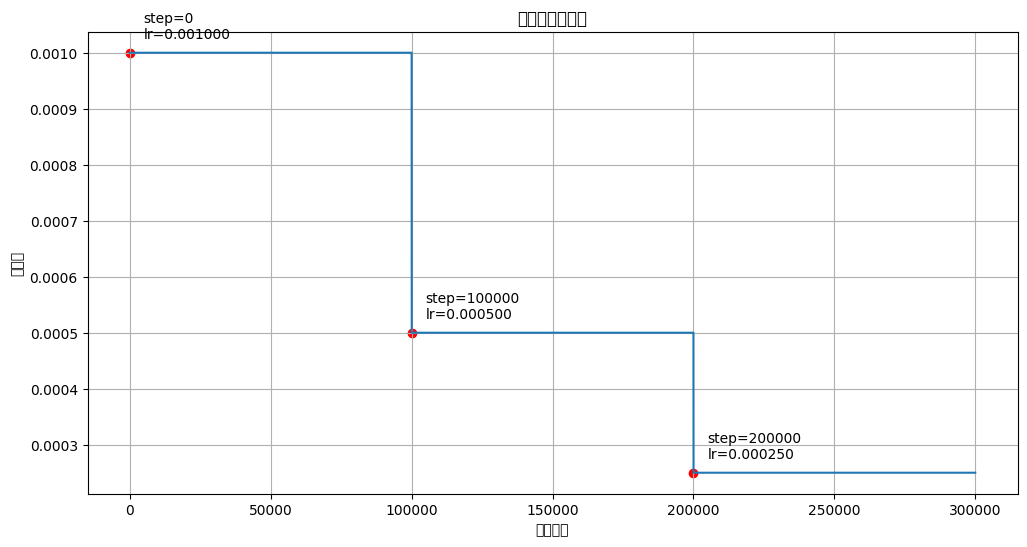

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
initial_lr = 0.001
gamma = 0.5
decay_step = 100000
total_steps = 300000  # 假设训练300k步

# 计算学习率
steps = np.arange(0, total_steps)
decay_times = np.maximum((steps - 2) // decay_step, 0)
lr = initial_lr * (gamma ** decay_times)

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(steps, lr)
plt.title('学习率衰减曲线')
plt.xlabel('训练步数')
plt.ylabel('学习率')
plt.grid(True)

# 添加关键点标注
key_steps = np.array([0, 100000, 200000])
key_lrs = initial_lr * (gamma ** (key_steps // decay_step))
plt.scatter(key_steps, key_lrs, color='red')
for step, lr_val in zip(key_steps, key_lrs):
    plt.annotate(f'step={step}\nlr={lr_val:.6f}', 
                (step, lr_val), 
                xytext=(10, 10),
                textcoords='offset points')

plt.show()

In [2]:
import os
from you_get import common as you_get

def download_douyin(url, path='./'):
    you_get.download(url, output_dir=path)

# 使用示例
url = "https://www.douyin.com/?enter_recommend_method=feed_click&recommend=1"
download_douyin(url)

AttributeError: 'OutStream' object has no attribute 'buffer'